### Perceptions of Urban Perception
Our perceptions of the urban landscape--sidewalks, buildings, roads--can differ wildly from the actual experience of neighborhoods. This project investigates the differences between perception and reality in terms of safety/crime in New York City neighborhoods. Which neighborhoods are perceived as more dangerous or safer than they actually are? What are the socioeconomic and physical features that characterize these neighborhoods? Answering these questions can help urban dwellers and policymakers understand the way urban perception is related to livability and guide future planning initiatives.

This notebook takes perceived safety, actual crime data, and other socioecnoic and physical data to answer these questions. I first develop a custom scoring mechanism to categorize neighborhoods as safer than perceived, neutral, or more dangerous than perceived. 

Once I have these scores and labels, I build linear and logistic regression models to predict the category of each neighborhood based on its socioeconomic and physical features, with the goal of understanding the key features that characterize each neighborhood type--what do the neighborhoods look like and who lives in them?

Diana Lam  
March 2016

#### Table of Contents
[1. Import modules and load pickled files](#1)  
[2. Normalize perceived danger and actual crime scores](#2)  
[3. Identify neighborhoods with high differences in actual vs. perceived scores](#3)  
[4. Cluster neighborhoods based on difference scores and variance](#4)  
[5. Investigate impacts of differences in perceived v. actual crime](#5)

### <a id='1'></a> 1. Import necessary modules and load pickled files

In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm, tqdm_pandas
import matplotlib.pyplot as plt
import seaborn as sns
import math
from collections import defaultdict
% matplotlib inline

from sklearn.base import TransformerMixin
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, RidgeCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier, RidgeClassifierCV, LogisticRegressionCV
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, Normalizer, Imputer

from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import roc_curve, auc, classification_report, mean_squared_error
from sklearn.grid_search import GridSearchCV

from fancyimpute import KNN

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
Using Theano backend.
//anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
def open_pkl(path):
    """Open pickle file."""
    with open(path, 'r') as picklefile:
        f = pickle.load(picklefile)
    return f

In [3]:
def to_pkl(path, name):
    "Pickle a file."
    with open(path, 'w') as picklefile:
        pickle.dump(name, picklefile)

In [4]:
with open('data/pickled/ss_withzip.pkl', 'r') as picklefile:
    ssp = pickle.load(picklefile)
    
with open('data/pickled/crime_withzip.pkl', 'r') as picklefile:
    crime = pickle.load(picklefile)

In [77]:
# split crime data into relevant years for sso and ssp data
crime2014 = crime[crime['Occurrence Year'] == 2014]

### <a id='2'></a> 2. Normalize perceived danger and crime scores

#### Perceived safety/crime scores

Normalize q-scores to 0-10 range.

In [6]:
def normalize(df, score_col, norm_col, range_start = 0, range_end = 10):
    """Normalize scores to fit within a given range.
    Args:
    df - data df
    score_col - column with unnormalized score
    norm_col - name of new column to store normalized scores
    range_start - start of the new range
    range_end - end of the new range
    """
    min_score = float(df[score_col].min())
    max_score = float(df[score_col].max())
    range_start = float(range_start)
    range_end = float(range_end)
    norm_func = lambda score: range_start + (float(score) - min_score) * (range_end - range_start) / (max_score - min_score)
    normalized = [norm_func(score) for score in df[score_col].tolist()]
    df.loc[:, norm_col] = normalized

Convert/invert q-score of safety to danger score.

In [7]:
# invert scores so higher score represents more perceived danger 
normalize(ssp, 'q-score', 'danger_score_raw', range_start = max(ssp['q-score']), range_end = min(ssp['q-score']))

Get average q-score by zip code.

In [8]:
# def agg_qscores(df, geo_col, score_col):
#     grouped = df.groupby(geo_col)
#     scores = pd.DataFrame(grouped[score_col].mean())
#     return scores

In [1285]:
# # perceived crime
# ssp_by_ct = agg_qscores(ssp, 'fips_tract', 'q_norm_rev')
# # sso_by_ct = agg_qscores(sso, 'fips_tract', 'q_norm_rev')

Map to shape file census tract.

In [8]:
tract_dict = open_pkl('data/pickled/TRACT_DICT.pkl')

Export for cartodb viz

In [10]:
def zip_to_cartodb(df, path):
    df['country'] = 'United States'
    df.to_csv(path)

In [11]:
def tract_to_cartodb(df, path):
    df['tract_copy'] = df.index.values
    df['tract_short'] = df.tract_copy.apply(lambda x: tract_dict[x] if x in tract_dict else '')
    df.drop('tract_copy', axis = 1, inplace = True)
    df.to_csv(path, index = False)

#### Actual crime scores

In [10]:
def get_crimes_by_geo(df, geo_col):
    """Given original crimes df, return df of counts by crime type by chosen geography."""
    byzip = df.groupby([geo_col, 'Offense'])
    crimesdf = byzip.OBJECTID.count().unstack(level=-1)
    crimesdf.fillna(0, inplace = True)
    crimesdf['total'] = crimesdf.sum(axis = 1)
    crimesdf[geo_col] = crimesdf.index
    return crimesdf

In [38]:
# fetch block group shape file reference data
bg_df = open_pkl('data/pickled/BLOCKGROUP_DF.pkl')

#### Clean crimes df v2 for 2010 data - hopefully cleaner! 
need any of this? not run - can delete everything in this section if no error

In [43]:
# # def clean_acs(df, geo_col, data_col, geo_col_name):
# #     """Given ACS zcta data file, return dictionary with key = zcta and values = data."""
# #     df[geo_col_name] = df[geo_col].apply(lambda x: int(x.split()[1]) if len(x.split()) > 1 else x)
# #     data_dict = dict(zip(df[geo_col_name].values, df[data_col].values.tolist()))
# #     return data_dict

def add_acs_data(acs_df, acs_geo_col, acs_data_col, df, df_geo_col, df_new_data_name):
    """Given ACS zcta data file, return dictionary with key = geography and values = data."""
    # create dictionary of {geo: value} from acs data
    data_dict = dict(zip(acs_df[acs_geo_col].values, acs_df[acs_data_col].values.tolist()))
    
    # fetch value for key and add to df 
    df[df_new_data_name] = df.loc[:, df_geo_col].apply(lambda x: int(data_dict[x]) if x in data_dict else np.nan)

In [37]:
# fetch resident and worker population data
# pop2010 = pd.read_csv('data/dem_data/census_pop_by_bg_2010.csv')
# workers2010 = pd.read_csv('data/dem_data/lehd_workers_2010.csv')
workers = pd.read_csv('data/dem_data/lehd_workers_2014.csv')
pop2014 = pd.read_csv('data/dem_data/acs_pop_by_bg_2014.csv')

In [39]:
def get_workers_by_bg(df):
    """Given df of lehd data, return df of total workers per block group."""
    df['block_group'] = df.loc[:, 'w_geocode'].apply(lambda x: str(x)[:12])
    by_bg = df.groupby('block_group')
    newdf = pd.DataFrame(by_bg['C000'].sum())
    newdf['block_group'] = newdf.index
    newdf.rename(columns = {'C000': 'total_workers'}, inplace = True)
    return newdf

In [40]:
def combine_workers_crime(wdf, cdf):
    worker_dict = dict(zip(wdf.block_group, wdf.total_workers))
    cdf['workers'] = cdf.fips_bg.apply(lambda x: worker_dict[x] if x in worker_dict else np.nan)

In [41]:
def normalize_crime(cdf, pdf, wdf):
    cdf2 = get_crimes_by_geo(cdf, 'fips_bg')
    wdf2 = get_workers_by_bg(wdf)
    combine_workers_crime(wdf2, cdf2)
    try:
        add_acs_data(pdf, 'GEO.id2', 'D001', cdf2, 'fips_bg', 'residents')
    except:
        add_acs_data(pdf, 'GEO.id2', 'HD01_VD01', cdf2, 'fips_bg', 'residents')
    
    # get combined population
    cdf2['total_pop'] = cdf2.loc[:, 'workers'] + cdf2.loc[:, 'residents']
    cdf2.dropna(inplace = True)
    
    # divide total crime by population
    cdf2['all_crimes_rate'] = cdf2.loc[:, 'total'] / cdf2.loc[:, 'total_pop'] * 1000
    
    # add geo area
    bg_dict = dict(zip(bg_df.GEOID10, bg_df.ALAND10))
    cdf2['area'] = cdf2.loc[:, 'fips_bg'].apply(lambda x: bg_dict[x] if x in bg_dict else np.nan)
    
    # only keep groups with residents > 0 AND total pop > 100
    cdf2 = cdf2[cdf2.residents > 0]
    cdf2 = cdf2[cdf2.total_pop > 100]
    
    return cdf2

In [44]:
# crime2010_bg = normalize_crime(crime2010, pop2010, workers2010)
crime2014_bg = normalize_crime(crime2014, pop2014, workers)

#### Normalize crime data by converting raw crime count to crime rates based on census tract worker and resident population.

In [68]:
def clean_acs_pop(df):
    keep = ['GEO.id2', 'HC01_VC03']
    newdf = df[keep]
    newdf.columns = ['tract', 'residents']
    newdf['tract'] = newdf.tract.astype(str)
    newdf.drop(0, inplace = True)
    return newdf

In [69]:
def clean_workers(df):
    """Given lehd df of worker by geo data, return df with workers aggregated by census tract."""
    df['tract'] = df.w_geocode.apply(lambda x: str(x)[:11])
    by_tract = df.groupby('tract')
    newdf = pd.DataFrame(by_tract['C000'].sum())
    newdf['tract'] = newdf.index
    newdf.rename(columns = {'C000': 'total_workers'}, inplace = True)
    return newdf

In [78]:
# get dataframe of crimes by geography
crime2014_ct = get_crimes_by_geo(crime2014, 'fips_tract')

In [79]:
# fetch population and worker data 
pop_ct = pd.read_csv('data/dem_data/acs_pop_by_ct_2014.csv')
workers = pd.read_csv('data/dem_data/lehd_workers_2014.csv')

In [80]:
# clean population and worker data; group by census tract 
pop_ct_clean = clean_acs_pop(pop_ct)

# add census tract to worker data
workers['tract'] = workers.w_geocode.apply(lambda x: str(x)[:12])
workers2 = clean_workers(workers)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [81]:
crime2014_ct.head()

Offense,BURGLARY,FELONY ASSAULT,GRAND LARCENY,GRAND LARCENY OF MOTOR VEHICLE,MURDER & NON-NEGL. MANSLAUGHTE,RAPE,ROBBERY,total,fips_tract
fips_tract,,,,,,,,,
36005000100,0,368,2,0,0,0,5,375,36005000100
36005000200,9,10,10,2,0,0,5,36,36005000200
36005000400,6,10,12,6,0,0,4,38,36005000400
36005001600,7,16,17,7,1,0,14,62,36005001600
36005001900,15,16,32,19,0,0,10,92,36005001900


In [82]:
# combine with crime df
crime2014_ct = crime2014_ct.merge(pop_ct_clean, how = 'left', left_on = 'fips_tract', right_on = 'tract')
worker_dict = dict(zip(workers2.tract, workers2.total_workers))
crime2014_ct['workers'] = crime2014_ct.fips_tract.apply(lambda x: worker_dict[x] if x in worker_dict else np.nan)

# get total population
crime2014_ct['total_pop'] = crime2014_ct.loc[:,'residents'].astype(float) + crime2014_ct.loc[:, 'workers'].astype(float)

In [83]:
# remove tracts with limited residents/population and get crime rate
crime2014_ct = crime2014_ct[crime2014_ct.total_pop > 1000] # remove tracts with total pop < 1000
crime2014_ct = crime2014_ct[crime2014_ct.residents > 0] # remove tracts with no residents
crime2014_ct['crime_rate_pop'] = (crime2014_ct.total / crime2014_ct.total_pop) * 1000

In [28]:
# normalize crime rate to be between 0 and 10 
# normalize(crime2014_ct, 'crime_rate_pop', 'crime_rate_pop_norm')

In [84]:
pop_info = crime2014_ct[['fips_tract', 'residents', 'workers', 'total_pop']]

### <a id='3'></a> 3. Identify and label areas with high differences between perceived and actual crime
Since the perceived scores are almost a black box in the sense that we cannot map them to actual number of crimes, let's use a score analogous to a z-score to compare the difference from the "average" relationship between perceived danger and actual crime rates. Using this scoring mechanism, we can identify areas that are above and below this mean, and therefore have differences in perceived vs. actual crime rates that deviate from the typical relationship. 

#### Clean up crime and perceived danger dfs.

In [54]:
# # clean up dfs
# crime_ols_2014 = clean_crimedf(crime2014_bg)
# # crime_ols_2010 = clean_crimedf(crime2010_bg)
# ssp_ols = clean_sspdf(ssp)
# # sso_ols = clean_ssodf_for_ols(sso)

# # merge with crime data; inner join to remove data pts without crime data
# ssp_ols = ssp_ols.merge(crime_ols_2014, left_on = 'fips_bg', right_on = 'fips_bg')
# # sso_ols = sso_ols.merge(crime_ols_2010, left_on = 'fips_bg', right_on = 'fips_bg')

In [117]:
def merge_crime_perceived(cdf, pdf):
    newdf = pdf.merge(cdf, left_on = 'fips_tract', right_on = 'tract')
    newdf.rename(columns = {'fips_tract_x': 'fips_tract'}, inplace = True)
    keep = ['fips_tract', 'danger_score_raw', 'residents', 'workers', 'total_pop', 'crime_rate_pop']
    return newdf[keep]

In [118]:
crime_perceived = merge_crime_perceived(crime2014_ct, ssp)

#### Compute difference scores and add neighborhood type labels.

In [103]:
# def delete_me(df, geo):
#     keep = [geo] + ['danger_score_raw', 'all_crimes_rate']
#     newdf = df[keep]
#     bygeo = newdf.groupby(geo)
#     stds = bygeo.std()
#     means = bygeo.mean()
#     medians = bygeo.median()
#     counts = bygeo.count()
#     aggdf = pd.DataFrame({geo: stds.index, 
#                          'danger_score_raw_mean': means.danger_score_raw,
#                          'danger_score_raw_median': medians.danger_score_raw, 
#                          'danger_score_raw_std': stds.danger_score_raw, 
#                          'crime_rate_mean': means.all_crimes_rate,
#                          'crime_rate_median': medians.all_crimes_rate,
#                          'crime_rate_std': stds.all_crimes_rate,
#                          'num_images': counts.danger_score_raw})
#     return aggdf

In [125]:
def agg_pred_scores(df, geo):
    """Get stats for crime and perceived danger scores by geography. Returns new df with scores
    by geography. 
    """
    keep = [geo] + ['danger_score_raw', 'crime_rate_pop']
    newdf = df[keep]
    bygeo = newdf.groupby(geo)
    stds = bygeo.std()
    means = bygeo.mean()
    medians = bygeo.median()
    counts = bygeo.count()
    aggdf = pd.DataFrame({geo: stds.index, 
                         'danger_score_raw_mean': means.danger_score_raw,
                         'danger_score_raw_median': medians.danger_score_raw, 
                         'danger_score_raw_std': stds.danger_score_raw, 
                         'crime_rate_mean': means.crime_rate_pop,
                         'crime_rate_median': medians.crime_rate_pop,
                         'num_images': counts.danger_score_raw})
    return aggdf

In [127]:
def med_abs_dev(arr):
    """Get median absolute deviation."""
    return np.median(np.abs(arr - np.median(arr)))/.6745

def mad_from_median(s):
    """Calculate standardized distance from the median using median absolute deviance.
    Implemented bc of outliers in dataset."""
    median = s.median()
    mad = np.median(np.abs(s - median))
    scores = [(data - median) / mad for data in s]
    return scores

#### Split neighborhoods three categories based on difference scores.
* **neutral/similar to perceived:** within one median absolute deviation of the median difference score
* **more dangerous than perceived:** over one median absolute deviation above median difference
* **safer than perceived:** over one median absolute deviation below median difference

In [130]:
def cluster_manual_med(df, score_col, data):
    """Categorize difference scores based on median absolute deviation from median and sort into clusters."""
    median = np.median(df[score_col])
#     mad = med_abs_dev(df[score_col])
    mad = np.median(np.abs(df[score_col] - median))
    lower_bound = median - mad
    upper_bound = median + mad
    
    # diff = crime rate - perceived danger 
    if data > upper_bound:
        return 'more_danger_tp' # actually more dangerous than perceived
    elif data <= upper_bound and data >= lower_bound:
        return 'similar_tp' # within 1 std of mean
    else:
        return 'safer_tp' # actually safer than perceived 
    
    
def add_ntype_labels(df, score_col):
    df['n_type'] = df.loc[:, score_col].apply(lambda x: cluster_manual_med(df, score_col, x))
    
    
def add_diff_zscore(df, score_col):
    """Create score from difference score to measure variation. For use in rgr model."""
    df['diff_zscore'] = mad_from_median(df.loc[:, score_col])

In [126]:
ssp_scores_tract = agg_pred_scores(crime_perceived, 'fips_tract')

In [128]:
# remove areas with limited residents and total population 
ssp_scores_tract = ssp_scores_tract.merge(pop_info, how = 'left', left_index = True, right_on = 'fips_tract')
ssp_scores_tract['residents'] = ssp_scores_tract.residents.astype(int)

# only keep tracts with resident pop > 100
ssp_scores_tract = ssp_scores_tract[ssp_scores_tract.residents > 100]

# rename columns
ssp_scores_tract.drop(['fips_tract_y', 'fips_tract_x'], axis = 1, inplace = True)

# median abs deviance from median
ssp_scores_tract['crime_rate_mad_from_med'] = mad_from_median(ssp_scores_tract.crime_rate_mean)
ssp_scores_tract['danger_score_mad_from_med'] = mad_from_median(ssp_scores_tract.danger_score_raw_mean)

# get difference in scores
# ssp_scores_tract['diff_std_from_mean'] = ssp_scores_tract.loc[:, 'crime_rate_std_from_mean'] - ssp_scores_tract.loc[:, 'danger_score_std_from_mean']
ssp_scores_tract['diff_mad_from_med'] = ssp_scores_tract.loc[:, 'crime_rate_mad_from_med'] - ssp_scores_tract.loc[:, 'danger_score_mad_from_med']

In [131]:
# add_manual_clusters(ssp_scores_tract, 'diff_std_from_mean')
add_ntype_labels(ssp_scores_tract, 'diff_mad_from_med')

# create score from difference score -- for use in rgr model
add_diff_zscore(ssp_scores_tract, 'diff_mad_from_med')

In [133]:
ssp_scores_tract.n_type.value_counts()

similar_tp        1041
more_danger_tp     548
safer_tp           493
Name: n_type, dtype: int64

Prep functions for regression models. 

In [36]:
def get_log(stat):
    if stat > 0:
        return math.log(stat)
    elif stat == 0:
        return math.log(stat + .001)
    else:
        return math.log(1 + stat)

In [37]:
def log_transform(col_name, df):
    df[col_name + '_log'] = df.loc[:, col_name].apply(lambda x: get_log(x))

Some quick plots to investigate data distribution.

In [43]:
def plot_scatter(x_col, y_col, df):
    """Make a scatter plot!"""
    plt.scatter(df[x_col], df[y_col], alpha = 0.5)
    plt.title('%s vs. %s' %(x_col, y_col))
    plt.xlabel('%s' %x_col)
    plt.ylabel('%s' %y_col)
    plt.show()

In [44]:
def plot_scatter_eval(x_col, y_col, df):
    """Make a scatter plot for model evaluation."""
    plt.scatter(df[x_col], df[y_col], alpha = 0.5)
    plt.title('%s vs. %s: MSE = %f' %(x_col, y_col, mean_squared_error(df[x_col], df[y_col])))
    plt.xlabel('%s' %x_col)
    plt.ylabel('%s' %y_col)
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    plt.show()

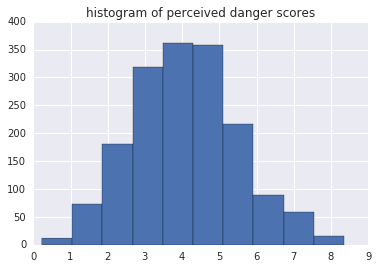

In [508]:
# plt.hist(sso_ols.danger_score_raw)
# plt.title('histogram of perceived danger scores');

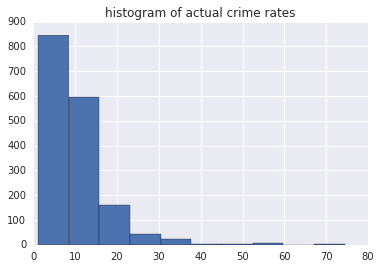

In [462]:
# plt.hist(sso_ols.all_crimes_rate)
# plt.title('histogram of actual crime rates');

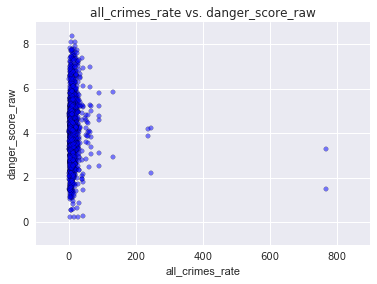

In [651]:
# plot_scatter('all_crimes_rate', 'danger_score_raw', sso_ols)

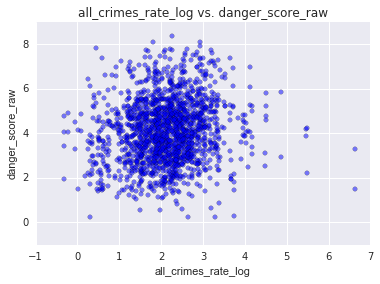

In [652]:
# plot_scatter('all_crimes_rate_log', 'danger_score_raw', sso_ols)

In [58]:
# crime_cols = ['burglary_rate', u'burglary_rate_log',
#        u'felony_assault_rate', u'felony_assault_rate_log',
#        u'grand_larceny_rate', u'grand_larceny_rate_log', u'murder_rate',
#        u'murder_rate_log', u'rape_rate', u'rape_rate_log', u'robbery_rate',
#        u'robbery_rate_log']

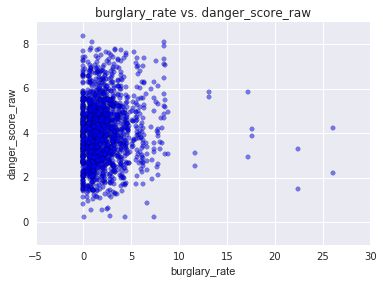

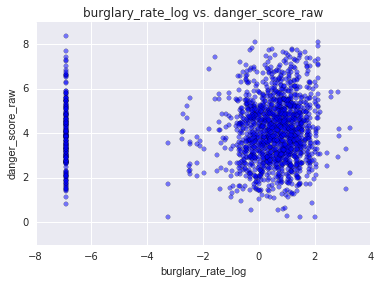

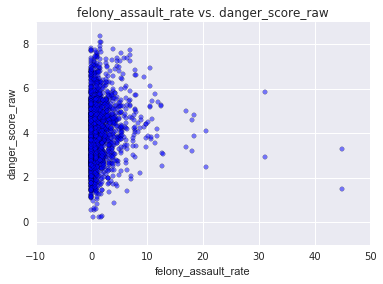

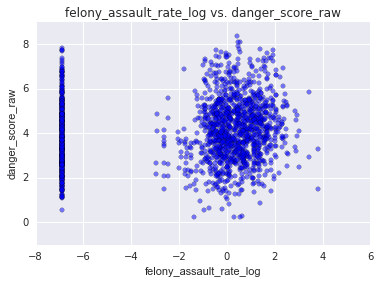

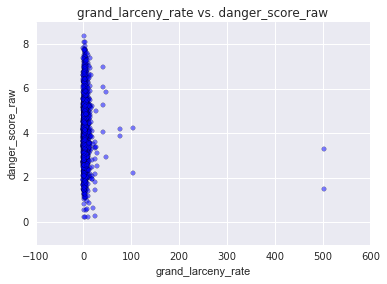

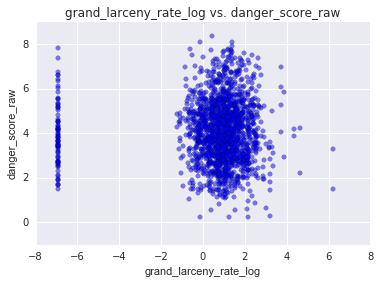

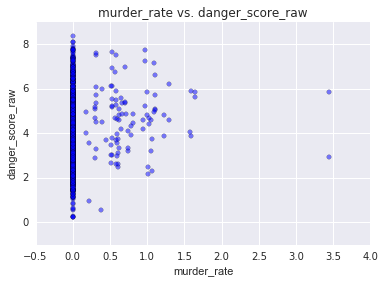

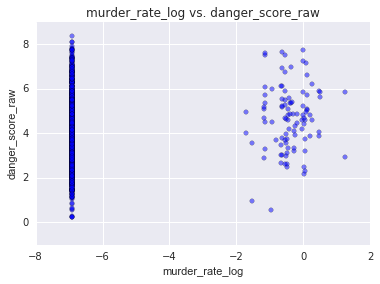

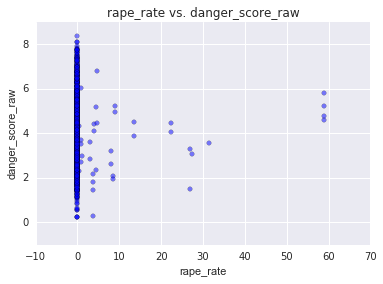

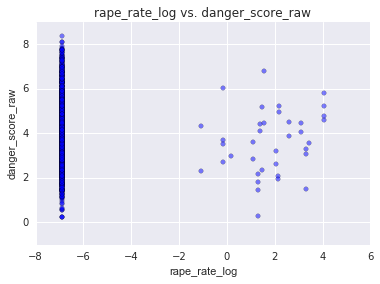

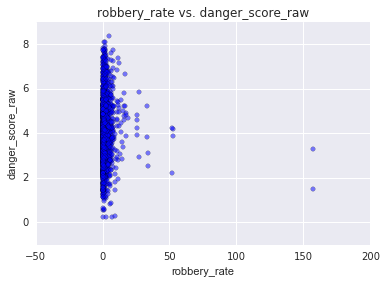

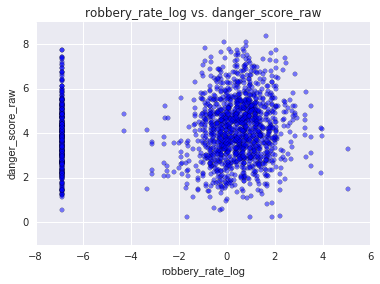

In [653]:
# for c in crime_cols:
#     plot_scatter(c, 'danger_score_raw', sso_ols)

Build linear regression models.

In [45]:
def get_dummies(df, cat_col):
    """Given df and categorical column, get dummies and reconcat."""
    cats = df[cat_col]
    cats = pd.get_dummies(cats, prefix = 'landuse')
    newdf = df.merge(cats, left_index = True, right_index = True)
    return newdf

In [46]:
def get_xy(features, ind, df, const = True):
    y = df[ind]
    X = df[features]
    if const == True:
        X = sm.add_constant(X)
    return X, y

In [47]:
def sm_ols(features, ind, df):
    """Build linear regression model using statsmodels given df and columns names of features and variable to predict.
    """ 
    y = df[ind]
    X = df[features]
    X = sm.add_constant(X)
    return sm.OLS(y, X).fit()

In [48]:
def rgr_lasso(features, ind, df):
    y = df[ind]
    X = df[features]
    X = sm.add_constant(X)
    m = LassoCV(cv = 5)
    m.fit(X, y)
    return m

In [49]:
def rgr_ridge(features, ind, df):
    y = df[ind]
    X = df[features]
    X = sm.add_constant(X)
    m = RidgeCV(cv = 5)
    m.fit(X, y)
    return m

In [50]:
def sm_sig_features(model):
    """Return names of features with p value < 0.05 for statsmodels rgr model."""
    return [model.pvalues.index[i] for i, p in enumerate(model.pvalues) if p < 0.05]

In [52]:
# load other socioeconomic data
edu = pd.read_csv('data/dem_data/acs_edu_attainment_25andolder_2014.csv') # done
home_value = pd.read_csv('data/dem_data/acs_med_home_value_2014.csv') # done
home_age = pd.read_csv('data/dem_data/acs_med_yr_house_built_2014.csv') # done
vacant_units = pd.read_csv('data/dem_data/acs_occupied_vacant_units_2010.csv') # done
home_type = pd.read_csv('data/dem_data/acs_housing_type_2014.csv')
income = pd.read_csv('data/dem_data/acs_med_hh_income_2014.csv') # done

In [53]:
def clean_median_data(data):
    """Clean high and low bounds of median data. Convert string to float."""
    try:
        if data[-1] == '-' or data[-1] == '+':
            try: 
                return float(data[:-1])
            except:
                return 0
        else:
            return float(data)
    except:
        return float(data)

In [54]:
def clean_acs(df, data_col, geo_name, data_name):
    """Clean acs data files with single column of data."""
    keep = ['GEO.id2', data_col]
    newdf = df[keep]
    newdf.rename(columns = {'GEO.id2': geo_name, data_col: data_name}, inplace = True)
    newdf.drop(0, inplace = True)
    newdf[data_name] = newdf.loc[:, data_name].apply(lambda x: clean_median_data(x))
    return newdf

In [55]:
def clean_acs_edu(df):
    """Calculate high school diploma attainment rates by geography."""
    keep = ['GEO.id2'] + [col for col in df.columns if 'HD01' in col]
    newdf = df[keep]
    metadata = newdf.loc[0, :]
    newdf.drop(0, inplace = True)
    newdf['hs_or_greater'] = newdf.loc[:, 'HD01_VD17':].astype(float).sum(axis = 1)
    newdf['pct_hs_or_greater'] = newdf.loc[:, 'hs_or_greater'] / newdf.loc[:, 'HD01_VD01'].astype(float)
    pctdf = newdf[['GEO.id2', 'pct_hs_or_greater']]
    pctdf.rename(columns = {'GEO.id2': 'block_group'}, inplace = True)
    return pctdf

In [56]:
def clean_acs_vacant_units(df):
    """Return percent vacant and occupied of total units by geography."""
    newdf = df.drop(['GEO.id', 'GEO.display-label'], axis = 1)
    newdf.drop(0, inplace = True)
    newdf['pct_occupied_units'] = newdf.loc[:, 'D002'].astype(float) / newdf.loc[:, 'D001'].astype(float)
    newdf['pct_vacant_units'] = newdf.loc[:, 'D003'].astype(float) / newdf.loc[:, 'D001'].astype(float)
    newdf.rename(columns = {'GEO.id2': 'block_group'}, inplace = True)
    return newdf[['block_group', 'pct_occupied_units', 'pct_vacant_units']]

In [57]:
def clean_acs_home_type(df):
    keep = ['GEO.id2'] + [col for col in df.columns if 'HD01' in col]
    newdf = df[keep]
    metadata = newdf.loc[0, :]
    newdf.drop(0, inplace = True)
    newdf['10_or_more_units'] = newdf.loc[:, 'HD01_VD07':'HD01_VD09'].astype(float).sum(axis = 1)
    newdf['pct_10_or_more_units'] = newdf.loc[:, '10_or_more_units'] / newdf.loc[:, 'HD01_VD01'].astype(float)
    pctdf = newdf[['GEO.id2', 'pct_10_or_more_units']]
    pctdf.rename(columns = {'GEO.id2': 'block_group'}, inplace = True)
    return pctdf

In [58]:
def multi_merge(df, merge_list, left_key = 'fips_bg', right_key = 'block_group'):
    for mdf in merge_list:
        df = df.merge(mdf, how = 'left', left_on = left_key, right_on = right_key)
    try:
        newdf = df.drop(['block_group_x', 'block_group_y'], axis = 1)
    except:
        newdf = df
    return newdf

### PLUTO FILES  
Land use codes:  
* 1-4 = residential  
* 5 = commercial & office  
* 6-7 = industrial & manufacturing/transportation & utility  
* 8 = public facilities and institutions  
* 9 = open space  
* 10 = parking  
* 11 = vacant 

In [59]:
def concat_pluto(df_paths):
    """Given pluto files, concat into one df."""
    df = pd.concat([pd.read_csv(path) for path in df_paths])
    return df

In [60]:
def make_fips(ct2010, cb2010, borough):
    state = '36'
    boro_dict = {'BX': '005', 'BK': '047', 'MN': '061', 'QN': '081', 'SI': '085' }
    try:
        ct2010 = str(int(ct2010))
        if len(ct2010) == 4:
            ct = ct2010 + '00'
        elif len(ct2010) == 3:
            ct = '0' + ct2010 + '00'
        elif len(ct2010) == 2:
            ct = '00' + ct2010 + '00'
        elif len(ct2010) == 1:
            ct = '000' + ct2010 + '00'
        else: 
            ct = ct2010
        try:
            return state + boro_dict[borough] + ct + str(int(cb2010))
        except:
            return state + boro_dict[borough] + ct
    except:
        return np.nan

In [61]:
def clean_pluto(df):
    """Given raw pluto df, add clean block groups and census tracts."""
    # get census tract and block numbers
    df.loc[:,'clean_block'] = df.apply(lambda row: make_fips(row.CT2010, row.CB2010, row.Borough), axis = 1)
    newdf = df.dropna(subset = ['clean_block'])
    newdf.loc[:,'block_group'] = newdf.loc[:, 'clean_block'].apply(lambda x: x[:12] if len(x) == 15 else np.nan)
    newdf.loc[:,'fips_tract'] = newdf.loc[:, 'clean_block'].apply(lambda x: x[:11])
    return newdf

In [62]:
def agg_pluto_by_geo(df, geo):
    """Given pluto df with fips codes, get primary landuse by geography."""
    # get predominant land use code by block group
    newdf = df.dropna(subset = [geo])
    mode = lambda x: x.mode() if len(x) > 2 else np.array(x)
    grouped = newdf.groupby(geo)['LandUse'].agg(lambda x: x.value_counts().index[0])
    grouped = pd.DataFrame(grouped)
    grouped[geo] = grouped.index
    grouped.loc[:, 'LandUse'] = grouped.loc[:, 'LandUse'].apply(lambda x: pluto_dict[x])
    return grouped

In [63]:
pluto14 = concat_pluto(['data/pluto/pluto_2014/BK.csv', 'data/pluto/pluto_2014/BX.csv', 
                      'data/pluto/pluto_2014/MN.csv', 'data/pluto/pluto_2014/QN.csv', 'data/pluto/pluto_2014/SI.csv'])

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (15,16,18,19,21,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (15,16,18,19,62,63,78) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (16,19,20,21,78) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (15,16,18,19,62,63,75,78) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3006: D

In [64]:
pluto_dict = {1: 'res_single_fam', 2: 'res_multi_fam_walkup', 3: 'res_multi_fam_elevator', 
              4: 'mixed_res_commercial', 5: 'office', 6: 'ind_manu', 7: 'transport_utility', 
              8: 'public_inst', 9: 'open_space', 10: 'parking', 11: 'vacant'}

In [65]:
pluto_clean = clean_pluto(pluto14)

//anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [66]:
landuse_tract = agg_pluto_by_geo(pluto_clean, 'fips_tract')
landuse = agg_pluto_by_geo(pluto_clean, 'block_group')

### /PLUTO FILES

In [67]:
# prep acs data
home_value_clean = clean_acs(home_value, 'HD01_VD01', 'block_group', 'med_home_value')
home_age_clean = clean_acs(home_age, 'HD01_VD01', 'block_group', 'med_yr_built')
income_clean = clean_acs(income, 'HD01_VD01', 'block_group', 'med_hh_income')
edu_clean = clean_acs_edu(edu)
vacant_units_clean = clean_acs_vacant_units(vacant_units)
home_type_clean = clean_acs_home_type(home_type)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main_

In [68]:
# merge with crime data
ssp_ols2 = multi_merge(ssp_ols, [home_value_clean, home_age_clean, income_clean, edu_clean, vacant_units_clean, home_type_clean, landuse])
ssp_ols2 = ssp_ols2.dropna()

sso_ols2 = multi_merge(sso_ols, [home_value_clean, home_age_clean, income_clean, edu_clean, vacant_units_clean, home_type_clean, landuse])
sso_ols2 = sso_ols2.dropna()

In [69]:
# get dummies for categorical variables
ssp_ols2 = get_dummies(ssp_ols2, 'LandUse')
sso_ols2 = get_dummies(sso_ols2, 'LandUse')

### <a id='4'></a> 4. Label census tracts based on variance and difference scores.

In [79]:
# def cluster_manual(df, score_col, data):
#     """Categorize difference scores based on standard deviations from the mean."""
#     mean = df[score_col].mean()
#     std = df[score_col].std()
#     lower_bound = mean - std
#     upper_bound = mean + std
    
#     # diff = crime rate - perceived danger 
#     if data > upper_bound:
#         return 0 # actually more dangerous than perceived
#     elif data <= upper_bound and data >= lower_bound:
#         return 1 # within 1 std of mean
#     else:
#         return 2 # actually safer than perceived 

In [81]:
# def add_manual_clusters(df, score_col):
#     df['manual_cluster_score'] = df.loc[:, score_col].apply(lambda x: cluster_manual(df, score_col, x))

In [1437]:
ssp_scores_tract.n_type.value_counts()

similar_tp        1041
more_danger_tp     529
safer_tp           512
Name: n_type, dtype: int64

In [1383]:
tract_to_cartodb(ssp_scores_tract, 'data/for_cartodb/scores_by_tract8.csv')

###  <a id='5'></a> 5. Build linear and logistic regression models to predict score/neighborhood category.

Features include:

**Physical**
* primary land use including vacancies (% sf by use of total built area, % lots by use of total bldg lots, primary land use in tract)  
* building age (median year buildings were built)  
* median building height & variation in building height  
* median assessed value  
* number of 311 complaints 
* transit access (number of subway stations in tract)

**Socioeconomic**  
* median household income
* housing affordability (housing and transportation costs as % of total income, median rent)
* unemployment rates

**Demographic**
* educational attainment (% aged 25+ with high school diplomas)
* household type (% non-family households)
* median age
* gender distribution   
* race (% non-white of total population)
* resident/worker population density

#### Clean features data & integrate with difference scores by tract.

Prep cleaning functions.

In [89]:
def clean_impacts_df(df):
    keep = ['crime_rate_std', 'danger_score_raw_median', 'danger_score_raw_std', 'diff_mad_from_med', 
            'n_type', 'diff_zscore', 'fips_tract']
    newdf = df[keep]
    return newdf

In [87]:
def clean_acs_income(df):
    """Clean acs income data by tract."""
    keep = ['GEO.id2', 'HC02_EST_VC02']
    newdf = df[keep]
    newdf.rename(columns = {'GEO.id2': 'tract', 'HC02_EST_VC02': 'median_hh_income'}, inplace = True)
    newdf.drop(0, inplace = True)
    newdf.loc[:, 'median_hh_income'].replace(['0', 0, '-'], np.nan, inplace = True)
    newdf.loc[2144, 'median_hh_income'] = np.nan
    newdf.loc[:, 'median_hh_income'] = newdf.loc[:, 'median_hh_income'].apply(clean_median_data)
    newdf.loc[:, 'median_hh_income'].fillna(newdf.median_hh_income.median(), inplace = True)
    newdf['median_hh_income_log'] = np.log(newdf.median_hh_income)
    return newdf

In [88]:
# affordability - housing and transportation costs as % of income
def clean_lai(df):
    keep = ['tract', 'hh_type1_ht_own', 'hh_type1_h_own', 'hh_type1_ht_rent', 'hh_type1_h_rent', 'hh_type1_ht', 'hh_type1_h']
    newdf = df[keep]
    newdf['tract'] = newdf.loc[:, 'tract'].apply(lambda x: x[1:-1])
    return newdf

In [90]:
def single_merge(odf, mdf, leftkey, rightkey):
    df = odf.merge(mdf, how = 'left', left_on = leftkey, right_on = rightkey)
    return df

In [94]:
def get_pop_density(df):
    """Get resident and worker density from crime df."""
    keep = ['population', 'workers', 'total_pop', 'tract_area']
    newdf = df[keep]
    newdf.rename(columns = {'population': 'residents'}, inplace = True)
    
    # add population density
    newdf['resident_density'] = newdf.loc[:, 'residents'] / newdf.loc[:, 'tract_area']
    newdf['worker_density'] = newdf.loc[:, 'workers'] / newdf.loc[:, 'tract_area']
    
    # add log of population density
    log_transform('resident_density', newdf)
    log_transform('worker_density', newdf)
    
    # add tract column
    newdf['tract'] = newdf.index
    
    return newdf

In [95]:
def pluto_builtsf(df):
    """Given clean pluto df, get sf type as % of all sf in tract."""
    newdf = pd.concat([df.loc[:, 'fips_tract'], df.loc[:, 'BldgArea':'OtherArea']], axis = 1)
    grouped = newdf.groupby('fips_tract').sum()
    grouped['pct_office'] = grouped.loc[:, 'OfficeArea'] / grouped.loc[:, 'BldgArea'].astype(float)
    grouped['pct_retail'] = grouped.loc[:, 'RetailArea'] / grouped.loc[:, 'BldgArea'].astype(float)
    grouped['pct_residential'] = grouped.loc[:, 'ResArea'] / grouped.loc[:, 'BldgArea'].astype(float)
    grouped['pct_ind'] = (grouped.loc[:, 'GarageArea'] + grouped.loc[:, 'StrgeArea'] 
                          + grouped.loc[:, 'FactryArea']) / grouped.loc[:, 'BldgArea'].astype(float)
    grouped['pct_other'] = grouped.loc[:, 'OtherArea'] / grouped.loc[:, 'BldgArea'].astype(float)
    grouped['tract'] = grouped.index
    return grouped[['tract', 'pct_office', 'pct_retail', 'pct_residential', 'pct_ind', 'pct_other']]

In [1461]:
def pluto_builtsf_raw_sf(df):
    newdf = pd.concat([df.loc[:, 'fips_tract'], df.loc[:, 'ResArea':'OtherArea']], axis = 1)
    grouped = newdf.groupby('fips_tract').sum()
    grouped['ind_area'] = grouped.loc[:, 'GarageArea'] + grouped.loc[:, 'StrgeArea'] + grouped.loc[:, 'FactryArea']
    grouped['tract'] = grouped.index
    return grouped[['tract', 'ResArea', 'OfficeArea', 'RetailArea', 'ind_area', 'OtherArea']]

In [96]:
def pluto_pct_landuse_lots(df):
    """Vacant lots as % of total. OR landuse codes as % of total lots."""
    newdf = df[['fips_tract', 'LandUse']]
    newdf.loc[:, 'LandUse'] = newdf.loc[:, 'LandUse'].apply(lambda x: pluto_dict[x] if x in pluto_dict else np.nan)
    newdf['dummy'] = 1
    grouped = newdf.groupby(['fips_tract', 'LandUse'])
    ldf = grouped.dummy.count().unstack(level = -1)
    ldf.fillna(0, inplace = True)
    for c in ldf.columns:
        ldf['lots_pct_' + c] = ldf.loc[:, c] / ldf.sum(axis = 1)
    ldf['lots_pct_low_density_use'] = ldf[['lots_pct_ind_manu', 'lots_pct_transport_utility', 
                                           'lots_pct_open_space', 'lots_pct_parking']].sum(axis = 1)
    ldf['lots_pct_residential'] = ldf[[col for col in ldf.columns if 'pct_res' in col]].sum(axis = 1)
    ldf['tract'] = ldf.index
    # UNIQUE = pct_office, pct_residential, pct_low_density, pct_vacant, pct_retail
    return ldf[[col for col in ldf.columns if 'pct' in col] + ['tract']]

In [97]:
def agg_pluto_by_geo(df, geo):
    """Given pluto df with fips codes, get primary landuse by geography."""
    # get predominant land use code by block group
    newdf = df.dropna(subset = [geo])
    mode = lambda x: x.mode() if len(x) > 2 else np.array(x)
    grouped = newdf.groupby(geo)['LandUse'].agg(lambda x: x.value_counts().index[0])
    grouped = pd.DataFrame(grouped)
    grouped[geo] = grouped.index
    grouped.loc[:, 'LandUse'] = grouped.loc[:, 'LandUse'].apply(lambda x: pluto_dict[x])
    return grouped

In [98]:
def pluto_single_feature(df, data_col):
    newdf = df[['fips_tract', data_col]]
    grouped = newdf.groupby('fips_tract')
    agg = pd.DataFrame({'tract': grouped.mean().index, 
                        'median_'+ data_col: grouped.median()[data_col], 
                        'avg_' + data_col: grouped.mean()[data_col], 
                        'std_'+ data_col: grouped.std()[data_col], 
                        'min_'+ data_col: grouped.min()[data_col],
                        'max_'+ data_col: grouped.max()[data_col]})
    return agg[['tract', 'avg_'+ data_col, 'median_'+ data_col, 'std_'+ data_col, 'min_'+ data_col, 'max_'+ data_col]]

In [99]:
pluto_useful = pd.concat([pluto_clean.loc[:, 'BldgArea':'OtherArea'], pluto_clean.loc[:, 'LandUse']], axis = 1)

In [100]:
def pluto_med_age(df, geo):
    """Get median building age by geography from pluto data."""
    newdf = df[df.YearBuilt != 0]
    newdf.dropna(subset = [geo], inplace = True)
    grouped = newdf.groupby(geo)['YearBuilt'].agg(lambda x: np.median(x))
    grouped = pd.DataFrame(grouped)
    grouped['tract'] = grouped.index
    return grouped

In [334]:
def clean_acs_gender(df):
    keep = ['GEO.id2', 'HC01_EST_VC01', 'HC02_EST_VC01', 'HC02_EST_VC06', 'HC02_EST_VC07', 'HC02_EST_VC08']
    newdf = df[keep]
    newdf.drop(0, inplace = True)
    newdf.replace('-', 0, inplace = True)
    newdf.loc[:,'pct_male'] = newdf.loc[:, 'HC02_EST_VC01'].astype(float) / newdf.loc[:, 'HC01_EST_VC01'].astype(float)
    newdf.loc[:, 'pct_male_15to29_of_males'] = (newdf.loc[:, 'HC02_EST_VC06'].astype(float) + newdf.loc[:, 'HC02_EST_VC07'].astype(float) + \
                                        newdf.loc[:, 'HC02_EST_VC08'].astype(float))/100
    newdf.loc[:, 'pct_male_15to29'] = newdf.loc[:, 'pct_male_15to29_of_males'].astype(float) * newdf.loc[:, 'pct_male'].astype(float)
    newdf.rename(columns = {'GEO.id2': 'tract'}, inplace = True)
    return newdf[['tract', 'pct_male','pct_male_15to29_of_males', 'pct_male_15to29']]

In [102]:
def clean_acs_race(df):
    keep = ['GEO.id2', 'D002', 'D003']
    newdf = df[keep]
    newdf.drop(0, inplace = True)
    newdf['race_pct_nonwhite'] = 1 - (newdf.loc[:, 'D003'].astype(float) / newdf.loc[:, 'D002'].astype(float))
    newdf.rename(columns = {'GEO.id2': 'tract'}, inplace = True)
    return newdf[['tract', 'race_pct_nonwhite']]

In [103]:
def clean_acs_hh_type(df):
    keep = ['GEO.id2', 'HC01_EST_VC02', 'HC05_EST_VC02']
    newdf = df[keep]
    newdf.drop(0, inplace = True)
    newdf.rename(columns = {'GEO.id2': 'tract', 'HC01_EST_VC02': 'total_hh', 'HC05_EST_VC02': 'nonfamily_hh'}, 
                 inplace = True)
    newdf['hh_type_pct_nonfamily'] = newdf.loc[:, 'nonfamily_hh'].astype(float) / newdf.loc[:, 'total_hh'].astype(int)
    return newdf[['tract', 'hh_type_pct_nonfamily']]

In [390]:
def clean_311_complaints(df):
    """Get number of 311 complaints in 2014 by census tract."""
    grouped = df.groupby('fips_tract')
    counts = pd.DataFrame(grouped.count()['Created Date'])
    counts.drop('no resul', inplace = True)
    counts['tract'] = counts.index
    counts.rename(columns = {'Created Date': 'num_311_complaints'}, inplace = True)
    # other feature stuff - complaints by population, type of complaints
    return counts

In [468]:
def clean_mta(df):
    grouped = df.groupby('fips_tract')
    counts = pd.DataFrame(grouped.count()['Division'])
    counts['tract'] = counts.index
    counts.rename(columns = {'Division': 'num_subway_stations'}, inplace = True)
    tract_data = pd.DataFrame(scores_for_impact.tract)
    merged = tract_data.merge(counts, how = 'left', left_on = 'tract', right_on = 'tract')
    merged.fillna(0, inplace = True)
    merged['has_subway'] = merged.num_subway_stations.apply(lambda x: 1 if x > 0 else 0)
    return merged

Import and clean features data.

In [91]:
# import raw features data 
edu_bt = pd.read_csv('data/dem_data/acs_edu_attainment_25andolder_2014_bt.csv')
income_bt = pd.read_csv('data/dem_data/acs_med_hh_income_2014_bt.csv')
lai = pd.read_csv('data/lai_data_36_tracts.csv')
lai_bg = pd.read_csv('data/lai_data_36_blkgrps.csv')


In [453]:
mta = open_pkl('data/pickled/mta_stations.pkl')

In [380]:
complaints = open_pkl('data/pickled/complaints_geo.pkl')

In [104]:
age = pd.read_csv('data/dem_data/acs_med_age_by_sex_2014.csv')
gender = pd.read_csv('data/dem_data/acs_sex_by_tract_2014.csv')
race = pd.read_csv('data/dem_data/census_race_by_tract_2010.csv')
rent = pd.read_csv('data/dem_data/acs_rent_by_tract_2014.csv')
emp = pd.read_csv('data/dem_data/acs_employment_by_tract_2014.csv')
hh_type = pd.read_csv('data/dem_data/acs_hh_type_by_tract_2014.csv')

In [106]:
edu_bt_clean = clean_acs_edu(edu_bt)
income_bt_clean = clean_acs_income(income_bt)
lai_clean = clean_lai(lai)

# median bldg age
bldg_age = pluto_med_age(pluto_clean, 'fips_tract')
gender_clean = clean_acs_gender(gender)
age_clean = clean_acs(age, 'HD01_VD02', 'tract', 'median_age')
race_clean = clean_acs_race(race)
density = get_pop_density(crime2014_ct)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be 

In [470]:
mta_clean = clean_mta(mta)

In [107]:
hh_type_clean = clean_acs_hh_type(hh_type)
sf_breakdown = pluto_builtsf(pluto_clean)
assessed_value = pluto_single_feature(pluto_clean, 'AssessTot')
bldg_heights = pluto_single_feature(pluto_clean, 'NumFloors')
landuse_lots = pluto_pct_landuse_lots(pluto_clean)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [1462]:
sf_breakdown_sf = pluto_builtsf_raw_sf(pluto_clean)

In [1465]:
to_pkl('data/pickled/sf_breakdown.pkl', sf_breakdown_sf)

In [ ]:
rent_clean = clean_acs(rent, 'HD01_VD01', 'tract', 'median_rent')
emp_clean = clean_acs(emp, 'HC04_EST_VC01', 'tract', 'unemp_rate')

In [391]:
complaints_clean = clean_311_complaints(complaints)

Merge with difference scores df.

In [1128]:
ssp_scores_tract = open_pkl('data/pickled/ssp_scores_tract_0327.pkl')

In [1438]:
scores_for_impact = clean_impacts_df(ssp_scores_tract)
scores_for_impact = single_merge(scores_for_impact, edu_bt_clean, leftkey = 'fips_tract', rightkey = 'block_group')
scores_for_impact = single_merge(scores_for_impact, income_bt_clean, leftkey = 'fips_tract', rightkey = 'tract')
scores_for_impact = single_merge(scores_for_impact, lai_clean, leftkey = 'fips_tract', rightkey = 'tract')
scores_for_impact = single_merge(scores_for_impact, landuse_tract, 'fips_tract', 'fips_tract')

In [1439]:
scores_for_impact = multi_merge(scores_for_impact, 
                                [bldg_age, gender_clean, age_clean, race_clean, hh_type_clean, 
                                 assessed_value, bldg_heights, density, rent_clean, emp_clean, 
                                 complaints_clean, landuse_lots, sf_breakdown, mta_clean],
                                left_key = 'fips_tract', right_key = 'tract')

# not significant = landuse_lots, sf_breakdown

In [1440]:
scores_for_impact.drop_duplicates(subset = 'fips_tract', inplace = True)
scores_for_impact.drop(['tract_x', 'tract_y'], axis = 1, inplace = True)

In [1441]:
to_pkl('data/pickled/ssp_scores_tract_0330.pkl', ssp_scores_tract)
to_pkl('data/pickled/scores_for_impact_0330.pkl', scores_for_impact)

#### Impute missing values in features

In [109]:
def get_nulls(df):
    """Get null values in df."""
    return df[pd.isnull(df).any(axis=1)]

In [111]:
class BasicImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with median of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [189]:
def impute_values(df, impute_type = 'basic'):
    """Impute values either by using median/mode or KNN algorithm. Specify impute_type = 'knn' to use KNN; 
    else defaults to basic. Return new df with imputed values.
    """
    if impute_type == 'basic':
        return BasicImputer().fit_transform(df)
    elif impute_type == 'knn':
        cat_cols = [col for col in df.columns if df[col].dtype == np.dtype('O')]
        cont_cols = [col for col in df.columns if col not in cat_cols]
        filled_knn = pd.DataFrame(KNN(k = 5).complete(df[cont_cols]), columns = cont_cols, index = df[cont_cols].index)
        filled_basic = BasicImputer().fit_transform(df[cat_cols])
        return pd.concat([filled_knn, filled_basic], axis = 1)

#### LINEAR REGRESSION MODEL: Predict continuous difference score using features to determine feature importance.
need to fix imputes here...

In [475]:
# knn impute
Xtrain_k_all_rgr, Xtest_k_all_rgr, ytrain_k_rgr, ytest_k_rgr = test_split_impute(
    'diff_zscore', scores_for_impact, impute = 'knn') 

Computing pairwise distances between 1627 samples
Computing distances for sample #1/1627, elapsed time: 0.164
Computing distances for sample #101/1627, elapsed time: 0.219
Computing distances for sample #201/1627, elapsed time: 0.285
Computing distances for sample #301/1627, elapsed time: 0.343
Computing distances for sample #401/1627, elapsed time: 0.389
Computing distances for sample #501/1627, elapsed time: 0.441
Computing distances for sample #601/1627, elapsed time: 0.499
Computing distances for sample #701/1627, elapsed time: 0.559
Computing distances for sample #801/1627, elapsed time: 0.615
Computing distances for sample #901/1627, elapsed time: 0.663
Computing distances for sample #1001/1627, elapsed time: 0.712
Computing distances for sample #1101/1627, elapsed time: 0.762
Computing distances for sample #1201/1627, elapsed time: 0.808
Computing distances for sample #1301/1627, elapsed time: 0.876
Computing distances for sample #1401/1627, elapsed time: 0.954
Computing distanc

In [566]:
land_use_features_tract = [col for col in Xtest_k_all_rgr if 'landuse' in col]

In [744]:
land_use_features_tract2 = ['landuse_ind_manu',
 'landuse_mixed_res_commercial',
 'landuse_office',
 'landuse_open_space',
 'landuse_public_inst',
 'landuse_transport_utility',
 'landuse_vacant']

In [1203]:
luf_sf = ['pct_retail', 'pct_residential', 'pct_ind', 'pct_office']
luf_lots = ['lots_pct_ind_manu', u'lots_pct_mixed_res_commercial',
       u'lots_pct_office', u'lots_pct_open_space', u'lots_pct_parking',
       u'lots_pct_public_inst', u'lots_pct_res_multi_fam_elevator',
       u'lots_pct_res_multi_fam_walkup', u'lots_pct_res_single_fam',
       u'lots_pct_transport_utility', u'lots_pct_vacant']

In [498]:
luf_lots_simple = ['lots_pct_office', 'lots_pct_residential', 'lots_pct_low_density_use', 'lots_pct_vacant']

In [411]:
# for actual model 
rgr_model_features = ['median_hh_income_log', 'hh_type1_ht', 'pct_hs_or_greater', 
                  'pct_male', 'YearBuilt', 'median_age',
                  'race_pct_nonwhite', 'hh_type_pct_nonfamily', 'median_AssessTot',
                  'median_NumFloors', 'std_AssessTot', 'std_NumFloors', 
                  'resident_density_log', 'worker_density_log', 'unemp_rate', 'median_rent', 
                      'pct_male_15to29', 'num_311_complaints', 'danger_score_raw_std'] + land_use_features_tract

In [569]:
rgr_model_features_trimmed = ['median_hh_income_log', 'hh_type1_ht', 
                      'pct_hs_or_greater', 
                      'pct_male', 'median_age', 
                      'YearBuilt',
                      'race_pct_nonwhite', 
                      'hh_type_pct_nonfamily', 
                      'median_AssessTot', 'std_AssessTot', 
                      'median_NumFloors', 'std_NumFloors', 
                      'resident_density_log', 'worker_density_log', 
                      'unemp_rate', 
                      'num_311_complaints', 
                      'danger_score_raw_std', 'has_subway'] + land_use_features_tract


# # ['lots_pct_vacant', 
#                                                                'lots_pct_residential', 'lots_pct_office', 
#                                                                'lots_pct_open_space', 'lots_pct_parking', 
#                                                                'lots_pct_public_inst', 'lots_pct_transport_utility']

# + land_use_features_tract

In [668]:
Xtrain_k_rgr, Xtest_k_rgr = get_model_tests(rgr_model_features_trimmed, Xtrain_k_all_rgr, Xtest_k_all_rgr)

In [663]:
def sm_ols2(xtrain, ytrain):
    xtrain = sm.add_constant(xtrain)
    return sm.OLS(ytrain, xtrain).fit()

In [672]:
def rgr_ridge2(xtrain, ytrain):
    xtrain = sm.add_constant(xtrain)
    m = RidgeCV(cv = 5)
    m.fit(xtrain, ytrain)
    return m

In [670]:
rgr_ridge??

In [690]:
ridge.alpha_

0.1

In [679]:
ridge = rgr_ridge2(Xtrain_k_rgr, ytrain_k_rgr)
sorted(zip(Xtrain_k_rgr.columns, ridge.coef_), key = lambda x: abs(x[1]), reverse = True)

[('landuse_public_inst', 12.390969239564518),
 ('landuse_mixed_res_commercial', -1.9639458152662967),
 ('median_AssessTot', 1.9511220632654598),
 ('hh_type_pct_nonfamily', 1.8490318282536555),
 ('landuse_vacant', -1.5204912751970463),
 ('median_age', 0.70081673031581304),
 ('landuse_open_space', -0.63764513379619259),
 ('pct_male', 0.60513576175918793),
 ('landuse_res_multi_fam_elevator', 0.53904265688733088),
 ('landuse_ind_manu', 0.52320348107148973),
 ('hh_type1_ht', -0.47438793771893895),
 ('unemp_rate', -0.19682094697256855),
 ('worker_density_log', 0.15181168620180574),
 ('has_subway', 0.13553136873839863),
 ('landuse_res_multi_fam_walkup', -0.1220239390258802),
 ('landuse_res_single_fam', 0.086067696178743061),
 ('landuse_transport_utility', -0.07932258883608706),
 ('landuse_office', -0.073604543306301756),
 ('std_NumFloors', 0.061951250379349794),
 ('resident_density_log', -0.022059743439403468),
 ('pct_hs_or_greater', 0.020285301367107253),
 ('YearBuilt', 0.016971571526517817)

In [669]:
rgr = sm_ols2(Xtrain_k_rgr, ytrain_k_rgr)
rgr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            diff_zscore   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     35.09
Date:                Sat, 26 Mar 2016   Prob (F-statistic):          1.86e-144
Time:                        21:14:43   Log-Likelihood:                -3290.2
No. Observations:                1627   AIC:                             6638.
Df Residuals:                    1598   BIC:                             6795.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------
const                             23.0110      5.980      3.848      0.000        11.282    34.740
median_hh_income_log              -0.4762      0.166     -2.862      0.004        -0.803    -0.150
hh_type1_ht                        0.0203      0.006      3.226      0.001         0.008     0.033
pct_hs_or_greater                  0.6128      0.625      0.981      0.327        -0.613     1.838
pct_male                           0.7317      0.963      0.760      0.447        -1.157     2.620
median_age                         0.0170      0.008      2.156      0.031         0.002     0.032
YearBuilt                         -0.0122      0.003     -4.240      0.000        -0.018    -0.007
race_pct_nonwhite                  1.8531      0.203      9.116      0.000         1.454     2.252
hh_type_pct_nonfamily              1.9551      0.431      4.541      0.000         1.111     2.800
median_AssessTot                9.673e-10   7.37e-10      1.313      0.189     -4.78e-10  2.41e-09
std_AssessTot                  -1.574e-08   7.42e-09     -2.121      0.034     -3.03e-08 -1.19e-09
median_NumFloors                   0.0611      0.043      1.419      0.156        -0.023     0.146
std_NumFloors                     -0.0212      0.044     -0.485      0.628        -0.107     0.065
resident_density_log               0.1505      0.071      2.126      0.034         0.012     0.289
worker_density_log                -0.1961      0.044     -4.432      0.000        -0.283    -0.109
unemp_rate                         0.0006      0.010      0.064      0.949        -0.019     0.020
num_311_complaints                 0.0002   9.48e-05      2.549      0.011      5.57e-05     0.000
danger_score_raw_std               0.1366      0.064      2.138      0.033         0.011     0.262
has_subway                         0.5217      0.129      4.058      0.000         0.269     0.774
landuse_ind_manu                  -1.7554      1.132     -1.551      0.121        -3.975     0.464
landuse_mixed_res_commercial       0.1447      1.114      0.130      0.897        -2.041     2.330
landuse_office                    -0.4220      1.133     -0.373      0.710        -2.644     1.800
landuse_open_space                12.7246      1.216     10.460      0.000        10.339    15.111
landuse_public_inst                0.7635      1.216      0.628      0.530        -1.621     3.148
landuse_res_multi_fam_elevator     0.1014      1.148      0.088      0.930        -2.151     2.354
landuse_res_multi_fam_walkup       0.3052      1.095      0.279      0.780        -1.842     2.452
landuse_res_single_fam             0.1410      1.091      0.129      0.897        -2.000     2.282
landuse_transport_utility         -1.3353      1.439     -0.928      0.353        -4.157     1.487
landuse_vacant

In [571]:
rgr = sm.OLS(ytrain_k_rgr, Xtrain_k_rgr).fit()
rgr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            diff_zscore   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     34.55
Date:                Sat, 26 Mar 2016   Prob (F-statistic):          1.62e-142
Time:                        20:43:45   Log-Likelihood:                -3297.8
No. Observations:                1627   AIC:                             6652.
Df Residuals:                    1599   BIC:                             6803.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------
median_hh_income_log              -0.2870      0.160     -1.798      0.072        -0.600     0.026
hh_type1_ht                        0.0216      0.006      3.412      0.001         0.009     0.034
pct_hs_or_greater                  0.3043      0.622      0.489      0.625        -0.916     1.525
pct_male                           1.0449      0.964      1.084      0.278        -0.845     2.935
median_age                         0.0134      0.008      1.711      0.087        -0.002     0.029
YearBuilt                         -0.0018      0.001     -1.824      0.068        -0.004     0.000
race_pct_nonwhite                  1.9014      0.204      9.331      0.000         1.502     2.301
hh_type_pct_nonfamily              2.1301      0.430      4.953      0.000         1.287     2.974
median_AssessTot                9.677e-10    7.4e-10      1.308      0.191     -4.84e-10  2.42e-09
std_AssessTot                  -1.627e-08   7.45e-09     -2.184      0.029     -3.09e-08 -1.66e-09
median_NumFloors                   0.0601      0.043      1.388      0.165        -0.025     0.145
std_NumFloors                     -0.0320      0.044     -0.730      0.465        -0.118     0.054
resident_density_log               0.1662      0.071      2.341      0.019         0.027     0.305
worker_density_log                -0.1995      0.044     -4.490      0.000        -0.287    -0.112
unemp_rate                         0.0043      0.010      0.434      0.664        -0.015     0.024
num_311_complaints                 0.0003   9.46e-05      2.983      0.003      9.67e-05     0.000
danger_score_raw_std               0.1616      0.064      2.531      0.011         0.036     0.287
has_subway                         0.5450      0.129      4.225      0.000         0.292     0.798
landuse_ind_manu                  -1.0020      1.119     -0.895      0.371        -3.198     1.194
landuse_mixed_res_commercial       1.0324      1.095      0.943      0.346        -1.115     3.179
landuse_office                     0.4191      1.116      0.375      0.707        -1.770     2.608
landuse_open_space                13.4688      1.206     11.167      0.000        11.103    15.835
landuse_public_inst                1.5564      1.203      1.293      0.196        -0.804     3.917
landuse_res_multi_fam_elevator     0.8530      1.136      0.751      0.453        -1.376     3.082
landuse_res_multi_fam_walkup       1.1587      1.077      1.076      0.282        -0.953     3.270
landuse_res_single_fam             0.9017      1.078      0.837      0.403        -1.213     3.016
landuse_transport_utility         -0.6964      1.435     -0.485      0.628        -3.512     2.119
landuse_vacant                    -1.2058      1.270     -0.950      0.342        -3.697     1.285
==============

In [638]:
rgr_imp_features = sm_sig_features(rgr)

In [639]:
Xtrain_k_rgr, Xtest_k_rgr = get_model_tests(rgr_imp_features, Xtrain_k_all_rgr, Xtest_k_all_rgr)
rgr2 = sm.OLS(ytrain_k_rgr, Xtrain_k_rgr).fit()
rgr2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            diff_zscore   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     83.62
Date:                Sat, 26 Mar 2016   Prob (F-statistic):          1.09e-138
Time:                        21:06:30   Log-Likelihood:                -3343.6
No. Observations:                1627   AIC:                             6707.
Df Residuals:                    1617   BIC:                             6761.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
hh_type1_ht               0.0148      0.005      2.906      0.004         0.005     0.025
race_pct_nonwhite         1.7014      0.179      9.491      0.000         1.350     2.053
hh_type_pct_nonfamily     1.1783      0.337      3.499      0.000         0.518     1.839
std_AssessTot          -1.69e-08   5.56e-09     -3.042      0.002     -2.78e-08    -6e-09
resident_density_log      0.4944      0.049     10.118      0.000         0.399     0.590
worker_density_log       -0.1161      0.035     -3.274      0.001        -0.186    -0.047
num_311_complaints        0.0002   9.16e-05      2.538      0.011      5.28e-05     0.000
danger_score_raw_std      0.0168      0.057      0.293      0.770        -0.096     0.129
has_subway                0.4813      0.130      3.713      0.000         0.227     0.736
landuse_open_space       13.1647      0.564     23.333      0.000        12.058    14.271
==============================================================================
Omnibus:                      823.699   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45387.057
Skew:                           1.586   Prob(JB):                         0.00
Kurtosis:                      28.680   Cond. No.                     1.21e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.21e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Predict neighborhood category (safer than perceived, more dangerous than perceived, on par) using classification

In [353]:
def test_split_impute(ind, modeldf, impute):
    """Split into train test set, impute values, get dummies, and return train and test dfs for model."""
    xcols = [col for col in modeldf.columns if ind not in col]
    Xtrain, Xtest, ytrain, ytest = train_test_split(modeldf[xcols], modeldf[ind], 
                                                    test_size = .25, random_state = 4444)
    Xtrain_filled = impute_values(Xtrain, impute_type = impute)
    Xtest_filled = impute_values(Xtest, impute_type = impute)
    return get_dummies(Xtrain_filled, 'LandUse'), get_dummies(Xtest_filled, 'LandUse'), ytrain, ytest

In [358]:
def get_model_tests(features, xtrain, xtest):
    return xtrain[features], xtest[features]

In [156]:
def test_split_dropna(features, ind, df):
    model_df = df[features + [ind]].dropna()
    Xtrain, Xtest, ytrain, ytest = train_test_split(
        model_df[features], model_df[ind], test_size = .25, random_state = 4444)
    return Xtrain, Xtest, ytrain, ytest

In [187]:
def classify_pipeline(xtrain, xtest, ytrain, ytest, model, scale = True):
    """Get accuracy, precision, recall, and f1 scores for model. 
    Include imputation and scaling in pipeline.
    Return model."""
    
#     # impute values for train and test set 
#     xtrain_filled = categorical_impute_xy(xtrain, ytrain)
#     xtest_filled = categorical_impute_xy(xtest, ytest)
    
    if scale == True:
        standard_scaler = StandardScaler()
        standard_scaler.fit(xtrain)
        X_train_scaled = standard_scaler.transform(xtrain)
        X_test_scaled = standard_scaler.transform(xtest)
        
        m = model.fit(X_train_scaled, ytrain)
        test_pred = m.predict(X_test_scaled)
#         pipeline = make_pipeline(StandardScaler(), model)
#         m = pipeline.fit(xtrain, ytrain)
        train_pred = m.predict(X_train_scaled)
    else:
        m = model.fit(xtrain, ytrain)
        test_pred = m.predict(xtest)
        train_pred = model.predict(xtrain)
        
    print 'train_accuracy:', accuracy_score(ytrain, train_pred)
    print 'test_accuracy:', accuracy_score(ytest, test_pred)
    print classification_report(ytest, test_pred)
    return m

In [369]:
def classify_pipeline_cv(x, y, model, scale = True):
    """Get accuracy, precision, recall, and f1 scores for model. 
    Include imputation and scaling in pipeline.
    Return model."""

    if scale == True:
        standard_scaler = StandardScaler()
        standard_scaler.fit(x)
        x_filled = standard_scaler.transform(x)
        
    acc = cross_val_score(model, x, y, cv = 5).mean()
    p = cross_val_score(model, x, y, cv = 5, scoring = 'precision_weighted').mean()
    r = cross_val_score(model, x, y, cv = 5, scoring = 'recall_weighted').mean()
    f1 = cross_val_score(model, x, y, cv = 5, scoring = 'f1_weighted').mean()
    
    print 'acc:', acc
    print 'precision:', p
    print 'recall:', r
    print 'f1:', f1, '\n'

In [178]:
def plot_feat_importances(Xtest, model):
    """Plot feature importances for trees/ensemble methods."""
    # prep
    importances = zip(Xtest.columns, model.feature_importances_)
    indices = np.argsort(model.feature_importances_)[::-1]
    forchart = sorted(importances, key = lambda x: x[1])
    chart_labels = [item[0] for item in forchart]
    chart_imps = [item[1] for item in forchart]
    
    # plot
    plt.figure(figsize = (10, 8))
    plt.barh(range(len(chart_imps)), chart_imps, align = 'center')
    plt.yticks(range(len(chart_imps)), chart_labels)
    plt.title('Feature Importances')
    plt.show()

In [123]:
def gs_svc(Xtrain, ytrain):
    scores = ['accuracy', 'precision', 'recall', 'f1']
    output = defaultdict(list)
    pipeline = make_pipeline(StandardScaler(), SVC())
    param = {
        'svc__C': [1, 10, 100, 1000],
        'svc__gamma': [0.001, 0.0001]}
    for score in scores: 
        print score, '\n'
        grid_search = GridSearchCV(pipeline, param_grid = param, verbose = 3, cv = 5, scoring = score)
        grid_search.fit(Xtrain, ytrain)
        output[score] = grid_search.best_score_, grid_search.best_params_
    return output, grid_search

In [124]:
def gs_gradient(Xtrain, ytrain):
    scores = ['precision', 'recall', 'f1', 'accuracy']
    output = defaultdict(list)
#     pipeline = make_pipeline(StandardScaler(), SVC())
    model = GradientBoostingClassifier()
    param = {
        'loss': ['deviance'],
        'min_samples_leaf': [1, 5, 10, 50],
        'max_depth': [1, 3, 5, 10]
    }
    for score in scores: 
        print score, '\n'
        grid_search = GridSearchCV(model, param_grid = param, verbose = 3, cv = 5, scoring = score)
        grid_search.fit(Xtrain, ytrain)
        output[score] = grid_search.best_score_, grid_search.best_params_
    return output, grid_search

In [1178]:
def get_coef(model, Xtest):
    coefs = {}
    coefs_odds = {} # impact on odds 
    for i in range(len(model.classes_)):
        coefs[model.classes_[i]] = sorted(zip(Xtest.columns, model.coef_[i]),  key = lambda x: abs(x[1]), reverse = True)
        coefs_odds[model.classes_[i]] = sorted(zip(Xtest.columns, np.exp(model.coef_[i]) -1),  key = lambda x: abs(x[1]), reverse = True)
    return coefs, coefs_odds

In [154]:
def baseline_model(xtest, ytest):
    pred = np.array(xtest.shape[0] * [ytest.mode()])
    print 'test_accuracy:', accuracy_score(ytest, pred)
    print classification_report(ytest, pred)

### CURRENT IMPUTES

#### OPEN PICKLED FILES

In [1112]:
scores_for_impact = open_pkl('data/pickled/scores_for_impact_0327.pkl')

In [1442]:
# knn impute - with staten island
Xtrain_k_all2, Xtest_k_all2, ytrain_k2, ytest_k2 = test_split_impute('n_type', scores_for_impact, impute = 'knn') 

Computing pairwise distances between 1561 samples
Computing distances for sample #1/1561, elapsed time: 0.198
Computing distances for sample #101/1561, elapsed time: 0.265
Computing distances for sample #201/1561, elapsed time: 0.325
Computing distances for sample #301/1561, elapsed time: 0.390
Computing distances for sample #401/1561, elapsed time: 0.455
Computing distances for sample #501/1561, elapsed time: 0.513
Computing distances for sample #601/1561, elapsed time: 0.582
Computing distances for sample #701/1561, elapsed time: 0.680
Computing distances for sample #801/1561, elapsed time: 0.781
Computing distances for sample #901/1561, elapsed time: 0.842
Computing distances for sample #1001/1561, elapsed time: 0.910
Computing distances for sample #1101/1561, elapsed time: 0.973
Computing distances for sample #1201/1561, elapsed time: 1.040
Computing distances for sample #1301/1561, elapsed time: 1.108
Computing distances for sample #1401/1561, elapsed time: 1.170
Computing distanc

In [1135]:
# knn impute
Xtrain_k_all, Xtest_k_all, ytrain_k, ytest_k = test_split_impute('n_type', scores_for_impact, impute = 'knn') 

Computing pairwise distances between 1482 samples
Computing distances for sample #1/1482, elapsed time: 0.242
Computing distances for sample #101/1482, elapsed time: 0.293
Computing distances for sample #201/1482, elapsed time: 0.366
Computing distances for sample #301/1482, elapsed time: 0.437
Computing distances for sample #401/1482, elapsed time: 0.491
Computing distances for sample #501/1482, elapsed time: 0.548
Computing distances for sample #601/1482, elapsed time: 0.602
Computing distances for sample #701/1482, elapsed time: 0.663
Computing distances for sample #801/1482, elapsed time: 0.731
Computing distances for sample #901/1482, elapsed time: 0.810
Computing distances for sample #1001/1482, elapsed time: 0.883
Computing distances for sample #1101/1482, elapsed time: 0.933
Computing distances for sample #1201/1482, elapsed time: 0.983
Computing distances for sample #1301/1482, elapsed time: 1.027
Computing distances for sample #1401/1482, elapsed time: 1.097
Imputing row 1/14

In [1136]:
# basic impute
Xtrain_b_all, Xtest_b_all, ytrain_b, ytest_b = test_split_impute('n_type', scores_for_impact, impute = 'basic') 

In [1204]:
clf_model_features_trimmed = ['median_hh_income_log', 'hh_type1_ht', 'median_rent',
                      'pct_hs_or_greater', 
                      'pct_male', 'median_age', 
                      'YearBuilt',
                      'race_pct_nonwhite', 
                      'hh_type_pct_nonfamily', 
                      'median_AssessTot', 'std_AssessTot', 
                      'median_NumFloors', 'std_NumFloors', 
                      'resident_density_log', 'worker_density_log', 
                      'unemp_rate', 
                      'num_311_complaints', 
#                       'danger_score_raw_std', 
                      'has_subway'] + luf_sf

In [1443]:
Xtrain_k2, Xtest_k2 = get_model_tests(clf_model_features_trimmed, Xtrain_k_all2, Xtest_k_all2)

In [1206]:
Xtrain_b, Xtest_b = get_model_tests(clf_model_features_trimmed, Xtrain_b_all, Xtest_b_all)

In [157]:
Xtrain_no_impute, Xtest_no_impute, ytrain_no_impute, ytest_no_impute = test_split_dropna(model_features, 'n_type', sfi)

#### REGRESSION CLASSIFIER

In [155]:
baseline_model(Xtest2, ytest2)

test_accuracy: 0.505660377358
             precision    recall  f1-score   support

more_danger_tp       0.00      0.00      0.00       132
   safer_tp       0.00      0.00      0.00       130
 similar_tp       0.51      1.00      0.67       268

avg / total       0.26      0.51      0.34       530



//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [1444]:
# logistic regression
logit_knn_l1 = classify_pipeline(Xtrain_k2, Xtest_k2, ytrain_k2, ytest_k2, 
                                             LogisticRegressionCV(penalty = 'l1', multi_class = 'ovr', solver = 'liblinear'), 
                              1)

train_accuracy: 0.609865470852
test_accuracy: 0.564299424184
             precision    recall  f1-score   support

more_danger_tp       0.53      0.19      0.28       136
   safer_tp       0.65      0.40      0.50       128
 similar_tp       0.55      0.84      0.67       257

avg / total       0.57      0.56      0.52       521



In [1215]:
# logistic regression
logit_knn = classify_pipeline(Xtrain_k, Xtest_k, ytrain_k, ytest_k, 
                                             LogisticRegressionCV(penalty = 'l2', multi_class = 'ovr'), 
                              1)

train_accuracy: 0.624831309042
test_accuracy: 0.552631578947
             precision    recall  f1-score   support

more_danger_tp       0.60      0.26      0.36       127
   safer_tp       0.57      0.42      0.48       132
 similar_tp       0.54      0.79      0.64       235

avg / total       0.56      0.55      0.53       494



In [1219]:
logit_knn.C_

array([ 0.04641589,  0.35938137,  0.04641589])

In [1159]:
# knn impute - no categories
ridgeclf_fixedimpute_knn = classify_pipeline(Xtrain_k, Xtest_k, ytrain_k, ytest_k, 
                                             RidgeClassifier(), 1)

train_accuracy: 0.621457489879
test_accuracy: 0.546558704453
             precision    recall  f1-score   support

more_danger_tp       0.56      0.28      0.37       127
   safer_tp       0.57      0.35      0.43       132
 similar_tp       0.54      0.80      0.65       235

avg / total       0.55      0.55      0.52       494



In [773]:
# basic impute - no categories
ridgeclf_fixedimpute_basic = classify_pipeline(Xtrain_b, Xtest_b, ytrain_b, ytest_b, LogisticRegression(), 1)

train_accuracy: 0.60909649662
test_accuracy: 0.576427255985
             precision    recall  f1-score   support

more_danger_tp       0.55      0.36      0.43       135
   safer_tp       0.66      0.38      0.48       140
 similar_tp       0.57      0.79      0.66       268

avg / total       0.59      0.58      0.56       543



In [774]:
classify_pipeline_cv(Xtrain_k, ytrain_k, RidgeClassifier()) # fix this...

acc: 0.570411580717
precision: 0.577850121821
recall: 0.570411580717
f1: 0.538005385938 



In [158]:
# compare to no impute
ridgeclf2 = classify_pipeline(Xtrain_no_impute, Xtest_no_impute, ytrain_no_impute, ytest_no_impute, RidgeClassifier(), 1)

train_accuracy: 0.52142279709
test_accuracy: 0.498789346247
             precision    recall  f1-score   support

more_danger_tp       0.25      0.01      0.02       116
   safer_tp       0.10      0.01      0.02        82
 similar_tp       0.51      0.95      0.66       215

avg / total       0.36      0.50      0.35       413



In [170]:
def plot_coefs(cdict):
    """Given dictionary of model coefficients, plot features."""
    for key in cdict:
        plt.figure(figsize = (10, 6))
        plt.barh(range(len(cdict[key])), 
                [feature[1] for feature in cdict[key]][::-1],
                tick_label = [feature[0] for feature in cdict[key]][::-1]
                )
        plt.title('Feature Impacts: %s' %key)
#         plt.savefig('presentation/%s.jpg' %key, dpi = 100)
        plt.show()

In [1200]:
labels_dict = {'danger_score_raw_std': ['perceived danger variance', 'phys'],
 'pct_residential': ['pct res sf', 'phys'],
 'resident_density_log': ['resident density', 'phys'],
 'worker_density_log': ['worker density', 'phys'],
 'pct_ind': ['pct industrial sf', 'phys'],
 'hh_type1_ht': ['housing costs', 'phys'],
 'YearBuilt': ['year built', 'phys'],
 'hh_type_pct_nonfamily': ['pct nonfamily households', 'se'],
 'std_NumFloors': ['bldg height variance', 'phys'],
 'median_age': ['population age', 'se'],
 'pct_hs_or_greater': ['edu attainment', 'se'],
 'pct_other': ['pct other sf', 'phys'],
 'race_pct_nonwhite': ['pct persons of color', 'se'],
 'median_hh_income_log': ['income', 'se'],
 'num_311_complaints': ['311 complaints', 'phys'],
 'pct_retail': ['pct residential sf', 'phys'],
 'pct_male': ['pct male', 'se'],
 'pct_office': ['pct office sf', 'phys'],
 'median_rent': ['median rent', 'phys'],
 'unemp_rate': ['unemployment rate', 'se'],
 'median_NumFloors': ['median bldg height', 'phys'],
 'std_AssessTot': ['property value variance', 'phys'],
 'median_AssessTot': ['median property value', 'phys'],
 'has_subway': ['transit access', 'phys']}

In [1273]:
colors_dict = {'phys': '#00AEF3', 'se': '#FF8101'}

In [1449]:
def plot_coefs2(cdict):
    sns.set_style("whitegrid")
    for key in cdict:
        plt.figure(figsize = (10, 7))
        plot = sns.barplot(y = [feature[0] for feature in cdict[key]][:5], x = [feature[1] for feature in cdict[key]][:5], 
                           palette = [colors_dict[labels_dict[feature[0]][1]] for feature in cdict[key]][:5],
                           orient = 'h')
        plot.set_yticklabels([labels_dict[feature[0]][0] for feature in cdict[key]], rotation = 0, fontsize = 12)
#         plt.title('Feature Impacts: %s' %key)
#         sns.despine()
        plt.savefig('presentation/%s_logit_odds_top5_v3.jpg' %key, dpi = 150, bbox_inches='tight')
        plt.show()

In [1118]:
# ridgeclf_coef_basic = get_coef(ridgeclf_fixedimpute_basic, Xtest_b)

In [1156]:
# ridgeclf_coef_knn = get_coef(ridgeclf_fixedimpute_knn, Xtest_k)

In [1445]:
logit_coef_knn_l1, logit_coef_odds_knn_l1 = get_coef(logit_knn_l1, Xtest_k2)

In [1208]:
logit_coef_knn, logit_coef_odds_knn = get_coef(logit_knn, Xtest_k)

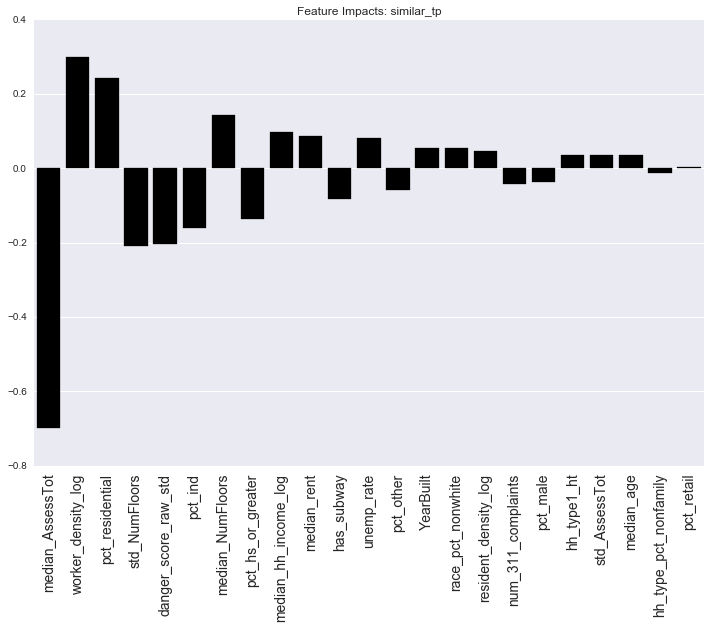

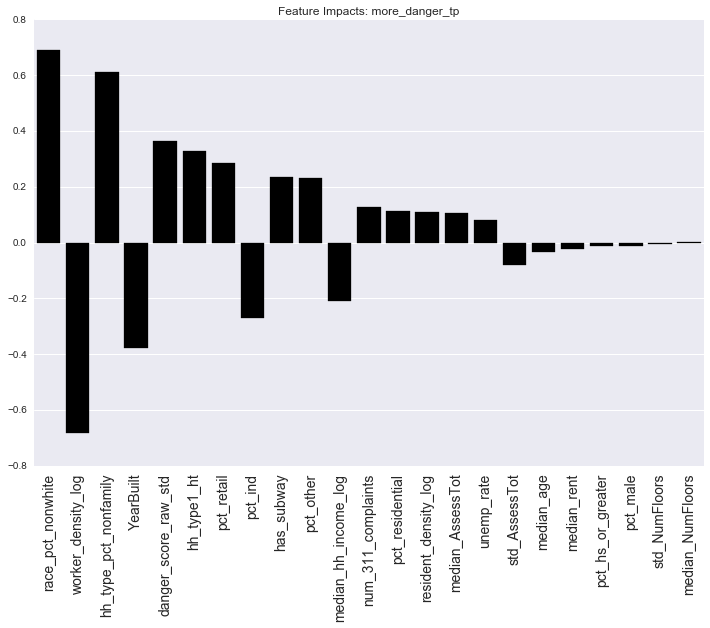

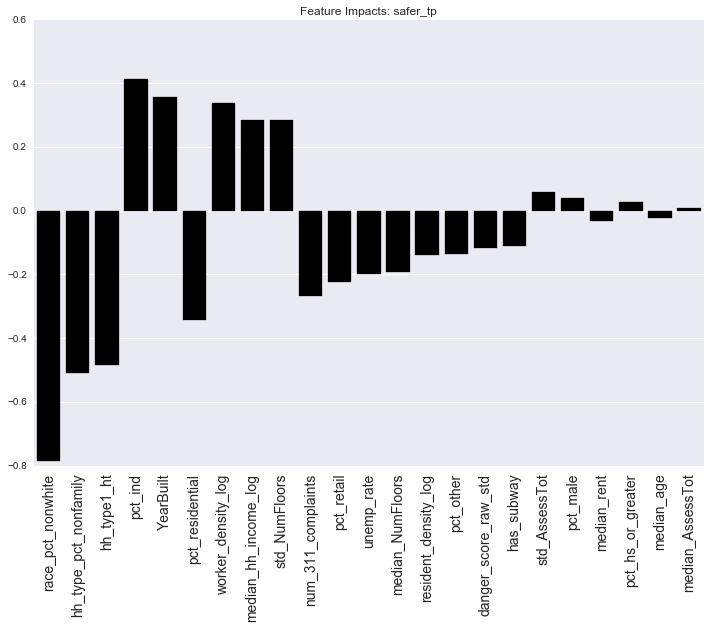

In [781]:
plot_coefs2(ridgeclf_coef_basic)

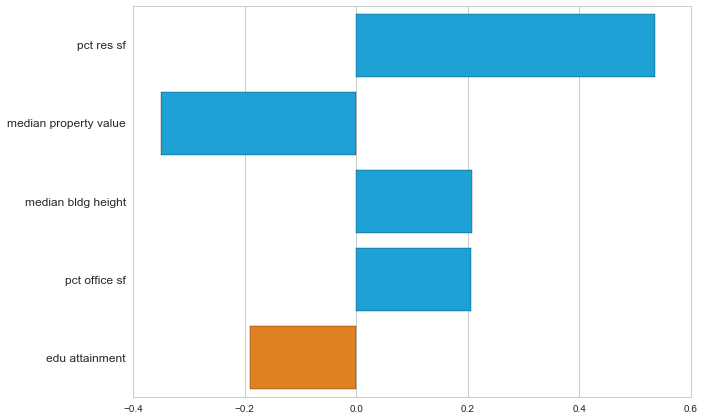

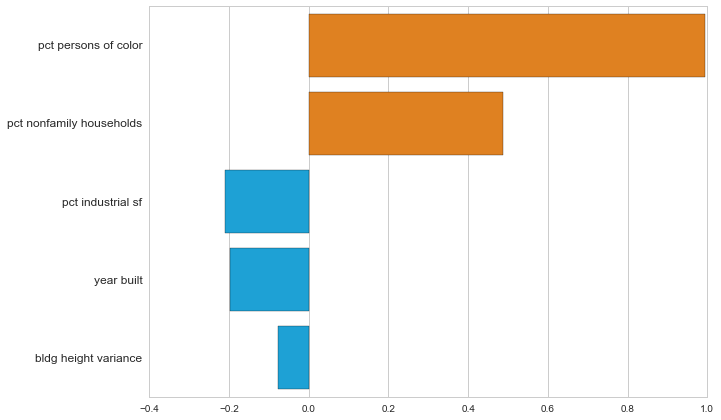

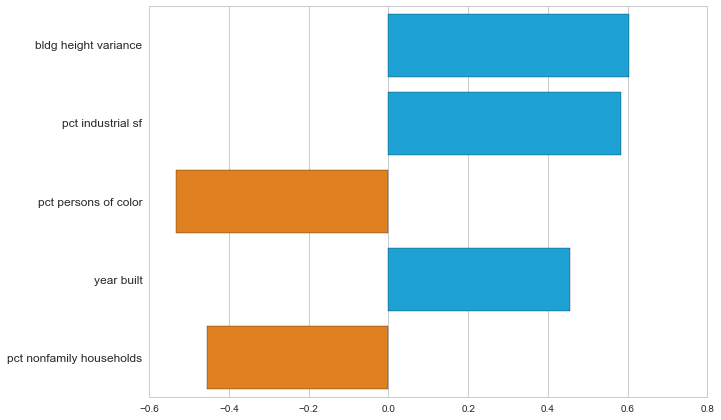

In [1450]:
plot_coefs2(logit_coef_odds_knn_l1)

In [1466]:
len(logit_coef_odds_knn_l1['more_danger_tp'])

22

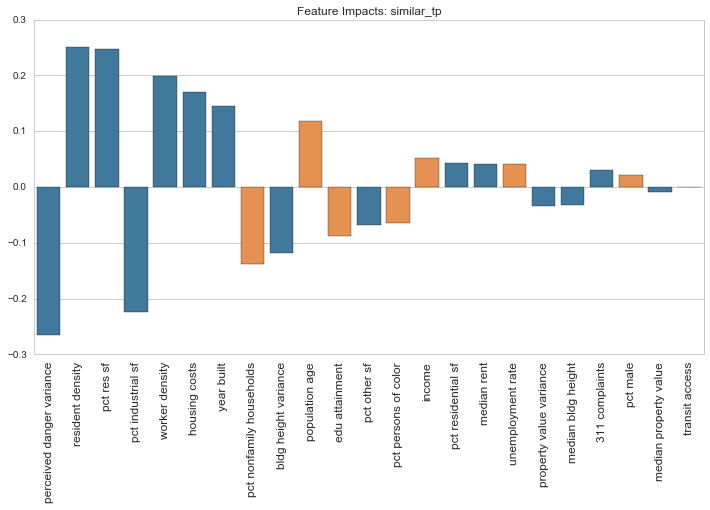

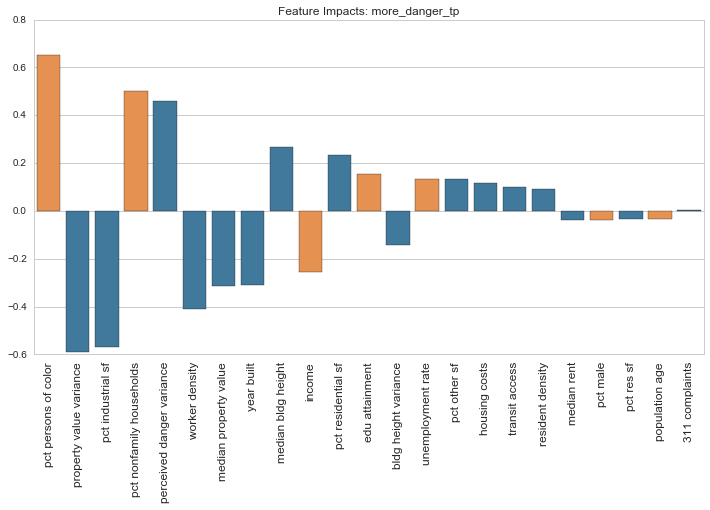

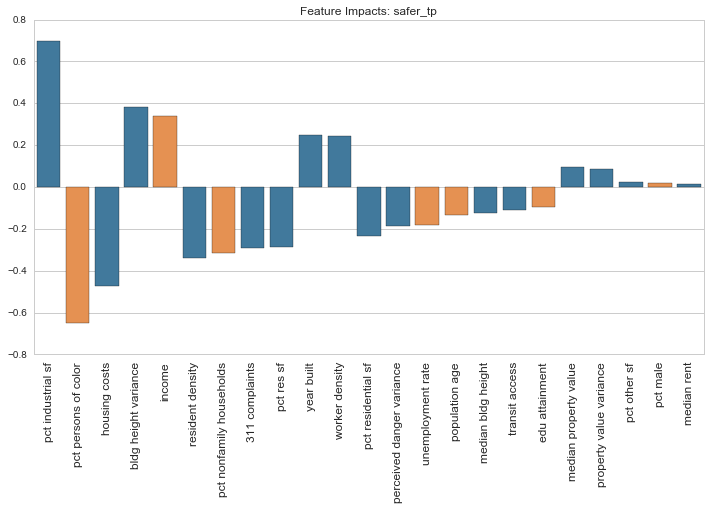

In [1173]:
plot_coefs2(logit_coef_knn)

Get impact on odds from coefficients.

In [1182]:
np.exp(0.6519192226239473)-1

0.91922070843440928

#### LINEAR SVM

In [163]:
gs_model.best_params_

{'svc__C': 1000, 'svc__gamma': 0.001}

In [778]:
# basic impute - no categories
svm_fixedimpute_basic = classify_pipeline(Xtrain_b, Xtest_b, ytrain_b, ytest_b, SVC(), 1)

train_accuracy: 0.715427166564
test_accuracy: 0.618784530387
             precision    recall  f1-score   support

more_danger_tp       0.65      0.30      0.41       135
   safer_tp       0.74      0.48      0.58       140
 similar_tp       0.59      0.85      0.69       268

avg / total       0.64      0.62      0.60       543



In [777]:
# knn impute - no categories
svm_fixedimpute_knn = classify_pipeline(Xtrain_k, Xtest_k, ytrain_k, ytest_k, SVC(), 1)

train_accuracy: 0.727105101414
test_accuracy: 0.611418047882
             precision    recall  f1-score   support

more_danger_tp       0.69      0.33      0.45       135
   safer_tp       0.68      0.44      0.53       140
 similar_tp       0.58      0.84      0.69       268

avg / total       0.63      0.61      0.59       543



#### ENSEMBLE METHODS

In [775]:
# basic impute - no categories
gbc_fixedimpute_knn = classify_pipeline(Xtrain_k, Xtest_k, ytrain_k, ytest_k, GradientBoostingClassifier(), 0)

train_accuracy: 0.861708666257
test_accuracy: 0.605893186004
             precision    recall  f1-score   support

more_danger_tp       0.58      0.39      0.47       135
   safer_tp       0.64      0.50      0.56       140
 similar_tp       0.60      0.77      0.68       268

avg / total       0.61      0.61      0.59       543



In [776]:
# basic impute - no categories
gbc_fixedimpute_basic = classify_pipeline(Xtrain_b, Xtest_b, ytrain_b, ytest_b, GradientBoostingClassifier(), 0)

train_accuracy: 0.854333128457
test_accuracy: 0.574585635359
             precision    recall  f1-score   support

more_danger_tp       0.51      0.34      0.41       135
   safer_tp       0.66      0.42      0.52       140
 similar_tp       0.57      0.77      0.66       268

avg / total       0.58      0.57      0.56       543



In [165]:
# no impute
gbc = classify_pipeline(Xtrain_no_impute, Xtest_no_impute, ytrain_no_impute, ytest_no_impute, GradientBoostingClassifier(n_estimators = 100), 0)

train_accuracy: 0.745351657235
test_accuracy: 0.484261501211
             precision    recall  f1-score   support

more_danger_tp       0.27      0.11      0.16       116
   safer_tp       0.33      0.05      0.09        82
 similar_tp       0.52      0.85      0.65       215

avg / total       0.41      0.48      0.40       413



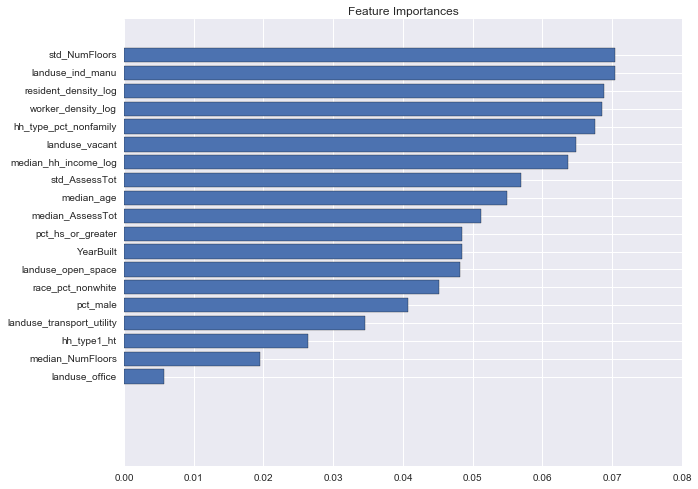

In [693]:
plot_feat_importances(Xtest, gbc_fixedimpute_knn)

In [265]:
classify_pipeline(Xtrain, Xtest, ytrain, ytest, RandomForestClassifier(), 0)

train_accuracy: 0.989937106918
test_accuracy: 0.615094339623
             precision    recall  f1-score   support

more_danger_tp       0.51      0.51      0.51       129
   safer_tp       0.72      0.55      0.63       137
 similar_tp       0.62      0.70      0.66       264

avg / total       0.62      0.62      0.61       530



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [169]:
classify_pipeline(Xtrain, Xtest, ytrain, ytest, RandomForestClassifier(), 0)

train_accuracy: 0.985970381917
test_accuracy: 0.546728971963
             precision    recall  f1-score   support

more_danger_tp       0.50      0.47      0.49       108
   safer_tp       0.46      0.36      0.40       102
 similar_tp       0.59      0.67      0.63       218

avg / total       0.54      0.55      0.54       428



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)